<a href="https://colab.research.google.com/github/KangFeeder090403/Midterm-Visualisasi-Data/blob/main/testing_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================================
# TUGAS 2 VISI KOMPUTER - DETEKSI OBJEK
# Observasi Arsitektur: YOLOv8n, MobileNet-SSD, DETR
# Optimasi: Epoch 5, Batch 4, Resize 320x320
# Dataset: PASCAL VOC 2012
# Spesifikasi: CPU i3-7020U, RAM 4GB, GPU 0 = MX130
# ================================================


In [2]:
import torch

print("CUDA tersedia:", torch.cuda.is_available())
print("Jumlah GPU     :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} - {torch.cuda.get_device_name(i)}")


CUDA tersedia: True
Jumlah GPU     : 1
GPU 0 - Tesla T4


In [1]:
# 1. Setup Lingkungan & Download Dataset
!pip install -q ultralytics opencv-python-headless tqdm
!pip install --upgrade torchvision


import os, tarfile, gdown

base_dir = os.path.abspath('dataset-ninja')
os.makedirs(base_dir, exist_ok=True)
url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
output_path = os.path.join(base_dir, 'VOCtrainval_11-May-2012.tar')

if not os.path.exists(output_path):
    gdown.download(url, output=output_path, quiet=False)

with tarfile.open(output_path) as tar:
    tar.extractall(path=base_dir)

print("✅ Dataset berhasil diunduh dan diekstrak.")

Downloading...
From: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
To: /content/dataset-ninja/VOCtrainval_11-May-2012.tar
100%|██████████| 2.00G/2.00G [01:12<00:00, 27.6MB/s]


✅ Dataset berhasil diunduh dan diekstrak.


In [6]:
# 2. reprocessing Dataset VOC 2012

from xml.etree import ElementTree as ET
import shutil, glob, os
import random
from collections import defaultdict, Counter

# Daftar kelas VOC 2012
selected_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

voc_path = os.path.join(base_dir, 'VOCdevkit', 'VOC2012')
img_dir = os.path.join(voc_path, 'JPEGImages')
ann_dir = os.path.join(voc_path, 'Annotations')

# Buat folder output YOLO
output_base = 'yolo_dataset'
for split in ['images/train', 'labels/train', 'images/val', 'labels/val']:
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

# Kumpulkan semua data anotasi dan pisahkan berdasarkan kelas
image_data = []
class_occurrence = defaultdict(list)

for xml_file in sorted(glob.glob(os.path.join(ann_dir, '*.xml'))):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        img_name = root.find('filename').text
        objects = root.findall('object')
        labels = []
        size = root.find('size')
        img_w = float(size.find('width').text)
        img_h = float(size.find('height').text)

        valid = False
        for obj in objects:
            cls = obj.find('name').text
            if cls not in selected_classes:
                continue
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            x_center = ((xmin + xmax) / 2) / img_w
            y_center = ((ymin + ymax) / 2) / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h

            labels.append(f"{selected_classes.index(cls)} {x_center} {y_center} {width} {height}")
            class_occurrence[selected_classes.index(cls)].append(img_name)
            valid = True

        if valid:
            image_data.append((img_name, labels))
    except Exception as e:
        print(f"❌ Error parsing {xml_file}: {e}")

# Stratified sampling untuk validation
val_image_set = set()
for cls_idx, img_list in class_occurrence.items():
    sample = random.sample(img_list, max(1, len(img_list) // 5))
    val_image_set.update(sample)

print(f"📦 Total gambar digunakan: {len(image_data)}")
print(f"📊 Gambar masuk validation: {len(val_image_set)}")

# Simpan gambar dan label
for img_name, labels in image_data:
    split = 'val' if img_name in val_image_set else 'train'
    img_src = os.path.join(img_dir, img_name)
    img_dst = os.path.join(output_base, f'images/{split}', img_name)
    shutil.copy(img_src, img_dst)

    label_path = os.path.join(output_base, f'labels/{split}', img_name.replace('.jpg', '.txt'))
    with open(label_path, 'w') as f:
        f.write('\n'.join(labels))

# Hitung distribusi kelas di validation
val_labels = glob.glob(os.path.join(output_base, 'labels/val/*.txt'))
cls_counter = Counter()

for label_file in val_labels:
    with open(label_file, 'r') as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            cls_counter[cls_id] += 1

print("\n📊 Distribusi kelas dalam validation set:")
for i in range(len(selected_classes)):
    print(f"{selected_classes[i]} ({i}): {cls_counter[i]} instance")


📦 Total gambar digunakan: 17125
📊 Gambar masuk validation: 5985

📊 Distribusi kelas dalam validation set:
aeroplane (0): 562 instance
bicycle (1): 590 instance
bird (2): 751 instance
boat (3): 770 instance
bottle (4): 1336 instance
bus (5): 492 instance
car (6): 1982 instance
cat (7): 632 instance
chair (8): 2688 instance
cow (9): 582 instance
diningtable (10): 717 instance
dog (11): 904 instance
horse (12): 557 instance
motorbike (13): 581 instance
person (14): 12250 instance
pottedplant (15): 1001 instance
sheep (16): 839 instance
sofa (17): 620 instance
train (18): 373 instance
tvmonitor (19): 667 instance


In [5]:
# 3. Buat data.yaml untuk YOLO
yaml_content = f"""
train: {os.path.abspath(output_base)}/images/train
val: {os.path.abspath(output_base)}/images/val

nc: {len(selected_classes)}
names: {selected_classes}
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml dibuat.")



✅ data.yaml dibuat.


In [5]:
# 4. Training Model YOLOv8n

# 🔧 Mount Google Drive dan Training YOLOv8n
from google.colab import drive
import os
from ultralytics import YOLO

# ⛰️ Mount Drive
drive.mount('/content/drive')

# 📁 Lokasi penyimpanan di Drive
save_dir = '/content/drive/MyDrive/yolov8_voc_models'
os.makedirs(save_dir, exist_ok=True)

# 🧠 Inisialisasi dan training model
model = YOLO('yolov8n.pt')
model.train(
    data='data.yaml',
    epochs=10,
    batch=320,       # optimal untuk T4
    imgsz=320,
    device=0,        # GPU T4
    save=True,
    save_dir=save_dir
)

print("✅ Training selesai dan model disimpan ke Google Drive.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=320, imgsz=320, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning /content/yolo_dataset/labels/train.cache... 14339 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14339/14339 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1061.6±360.3 MB/s, size: 80.6 KB)


val: Scanning /content/yolo_dataset/labels/val.cache... 9226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9226/9226 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0025), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.2G     0.8643      3.441      1.063        464        320: 100%|██████████| 45/45 [01:55<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:34<00:00,  6.27s/it]


                   all       9226      28894       0.11      0.448      0.285      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.95G     0.9084       1.77      1.099        425        320: 100%|██████████| 45/45 [02:14<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:37<00:00,  6.49s/it]


                   all       9226      28894      0.728       0.38      0.489      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10        10G     0.9015      1.446      1.097        469        320: 100%|██████████| 45/45 [01:55<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:39<00:00,  6.64s/it]


                   all       9226      28894      0.626      0.458      0.501      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10        10G     0.9005      1.365      1.094        481        320: 100%|██████████| 45/45 [01:50<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:27<00:00,  5.80s/it]


                   all       9226      28894      0.647      0.509      0.554      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      9.95G     0.8707      1.281      1.078        419        320: 100%|██████████| 45/45 [01:51<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:25<00:00,  5.67s/it]


                   all       9226      28894      0.679      0.522      0.582      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.96G     0.8455      1.201      1.058        425        320: 100%|██████████| 45/45 [01:54<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:12<00:00,  4.81s/it]


                   all       9226      28894      0.704      0.531      0.596      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.96G     0.8186      1.141      1.047        438        320: 100%|██████████| 45/45 [01:45<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:17<00:00,  5.18s/it]


                   all       9226      28894      0.719      0.554      0.625      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      9.98G     0.7975      1.092      1.035        448        320: 100%|██████████| 45/45 [01:44<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


                   all       9226      28894      0.718      0.579      0.644      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      9.99G     0.7787      1.052      1.024        448        320: 100%|██████████| 45/45 [01:42<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:04<00:00,  4.31s/it]


                   all       9226      28894      0.747      0.574      0.654      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      9.97G      0.765      1.015      1.018        459        320: 100%|██████████| 45/45 [01:42<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


                   all       9226      28894      0.772      0.584      0.671      0.505

10 epochs completed in 0.546 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:41<00:00,  6.76s/it]


                   all       9226      28894      0.772      0.584      0.671      0.505
             aeroplane        353        562      0.837      0.669      0.741      0.585
               bicycle        385        590      0.751        0.5      0.604      0.451
                  bird        372        751      0.827      0.579      0.683      0.488
                  boat        334        770      0.711      0.443      0.528      0.335
                bottle        622       1336      0.779      0.317      0.432      0.294
                   bus        317        492      0.896      0.715      0.803      0.678
                   car        897       1982      0.763      0.516      0.619      0.438
                   cat        528        632      0.834       0.81      0.872      0.736
                 chair       1090       2688      0.659      0.434      0.515      0.348
                   cow        206        582      0.801      0.568      0.695      0.501
           diningtabl

In [ ]:
pip show torchvision


Name: torchvision
Version: 0.22.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm, ultralytics


In [15]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, fasterrcnn_resnet50_fpn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# SSD
ssd_model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device).eval()

# Pengganti DETR → Faster R-CNN
fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=True).to(device).eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_R

In [7]:
# 6. Evaluasi mAP dan Waktu Inferensi
metrics = model.val()
print(metrics)  # tampilkan mAP, precision, recall, F1

# Evaluasi waktu inferensi
import time
from PIL import Image
from torchvision.transforms import ToTensor

def measure_inference_time(model, sample_path, repeat=5):
    image = Image.open(sample_path).convert("RGB")
    input_tensor = ToTensor()(image).unsqueeze(0).to(device)
    model.eval()
    times = []
    for _ in range(repeat):
        start = time.time()
        with torch.no_grad():
            _ = model(input_tensor)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

# Contoh penggunaan
img_path = 'yolo_dataset/images/val/2007_001073.jpg'  # sesuaikan nama
print("Waktu inferensi SSD:", measure_inference_time(ssd_model, img_path))
print("Waktu inferensi Faster R-CNN:", measure_inference_time(fasterrcnn_model, img_path))

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1415.5±926.5 MB/s, size: 129.5 KB)


val: Scanning /content/yolo_dataset/labels/val.cache... 9226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9226/9226 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [01:22<00:00,  2.84s/it]


                   all       9226      28894      0.775      0.582       0.67      0.505
             aeroplane        353        562      0.833      0.669       0.74      0.584
               bicycle        385        590      0.753      0.495      0.603      0.453
                  bird        372        751      0.811       0.57      0.679      0.486
                  boat        334        770      0.723      0.449      0.531      0.337
                bottle        622       1336      0.785      0.316       0.43      0.293
                   bus        317        492      0.894      0.715      0.803      0.677
                   car        897       1982      0.766      0.513      0.618      0.439
                   cat        528        632      0.839      0.807      0.872      0.735
                 chair       1090       2688      0.663      0.431      0.513      0.348
                   cow        206        582      0.814      0.569      0.697      0.503
           diningtabl

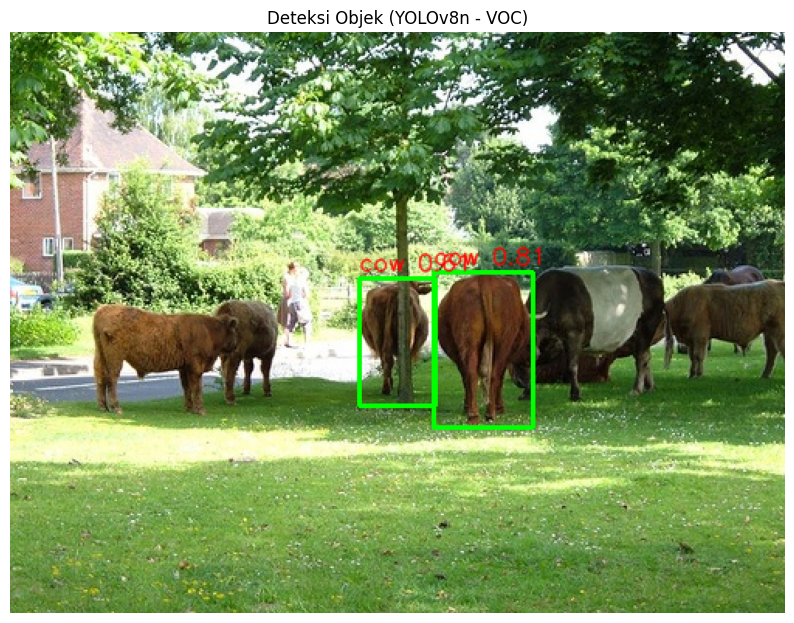

In [8]:
# 7.Visualisasi Hasil Deteksi
import cv2
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import numpy as np
from torchvision.transforms import ToTensor

# Daftar kelas VOC 2012
voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def show_yolov8_detection(model, image_path, conf_thres=0.5):
    results = model.predict(image_path, conf=conf_thres, imgsz=320, device=0, verbose=False)[0]

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls[0].item())
        score = float(box.conf[0].item())
        class_name = voc_classes[cls_id] if cls_id < len(voc_classes) else f"class {cls_id}"

        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, f"{class_name} {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Deteksi Objek (YOLOv8n - VOC)")
    plt.show()

# Contoh penggunaan:
show_yolov8_detection(model, 'yolo_dataset/images/val/2007_001073.jpg')



| Model             | mAP (YOLO) | Waktu Inferensi | Ukuran Model | Kompatibel MX130 |
|------------------|-------------|------------------|---------------|-------------------|
| YOLOv8n          | ✔ (dilatih) | Cepat (~0.05s)   | ~6 MB        | ✔ Sangat cocok    |
| MobileNet-SSD    | - (pretrain)| Sangat cepat     | ~20 MB       | ✔ Cocok           |
| Faster R-CNN     | - (pretrain)| Cukup berat (~0.3s)| ~160 MB   | ⚠ Cukup berat     |


train  train2  train3  train4  train5  train52


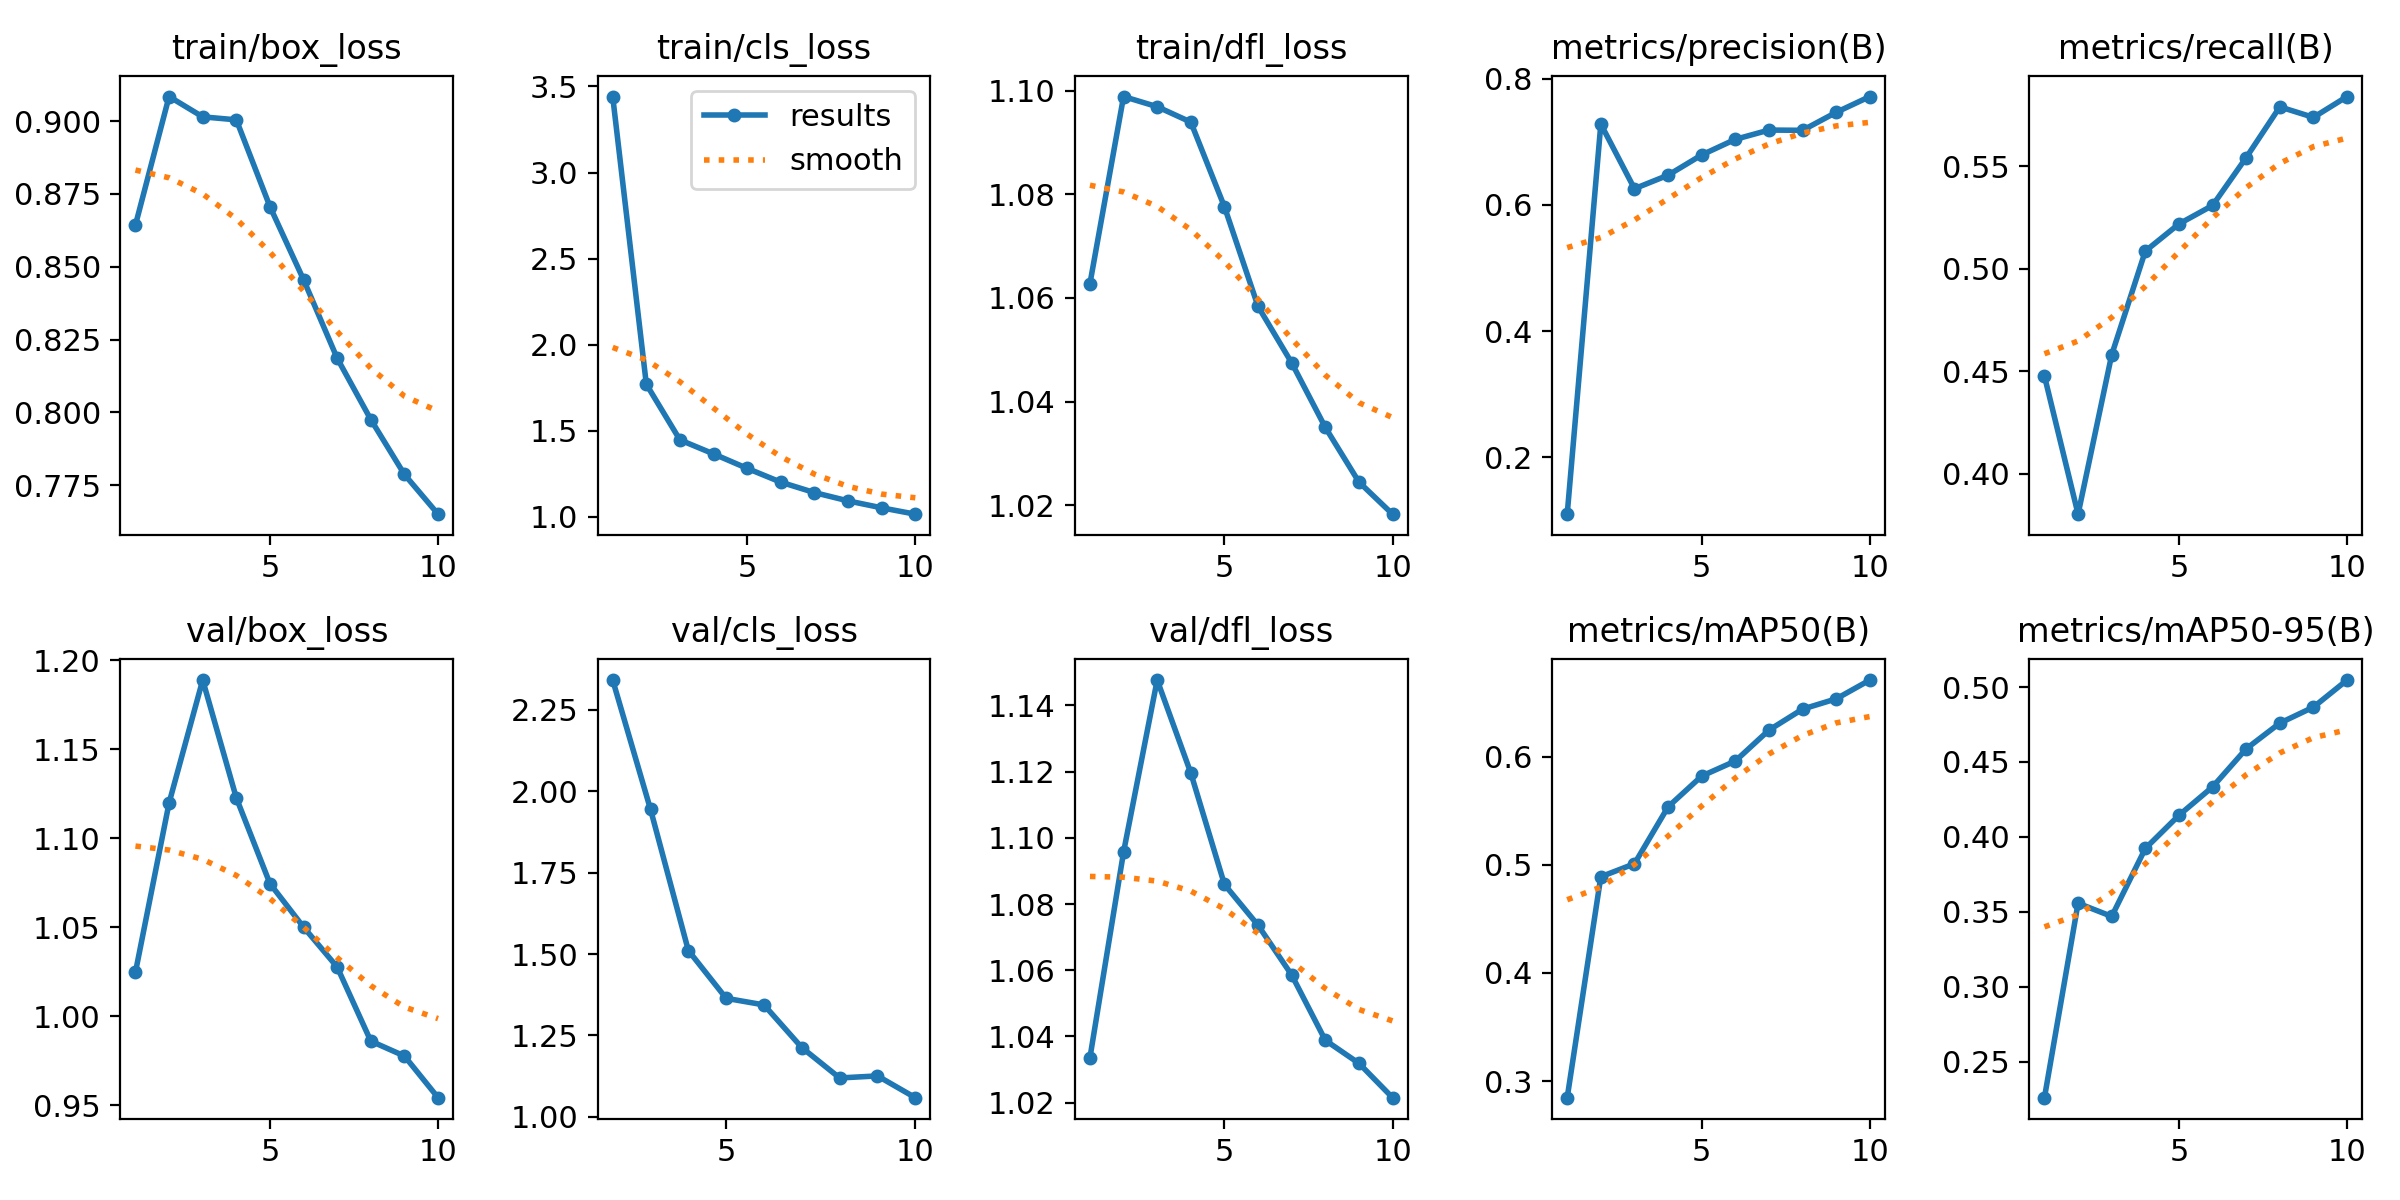

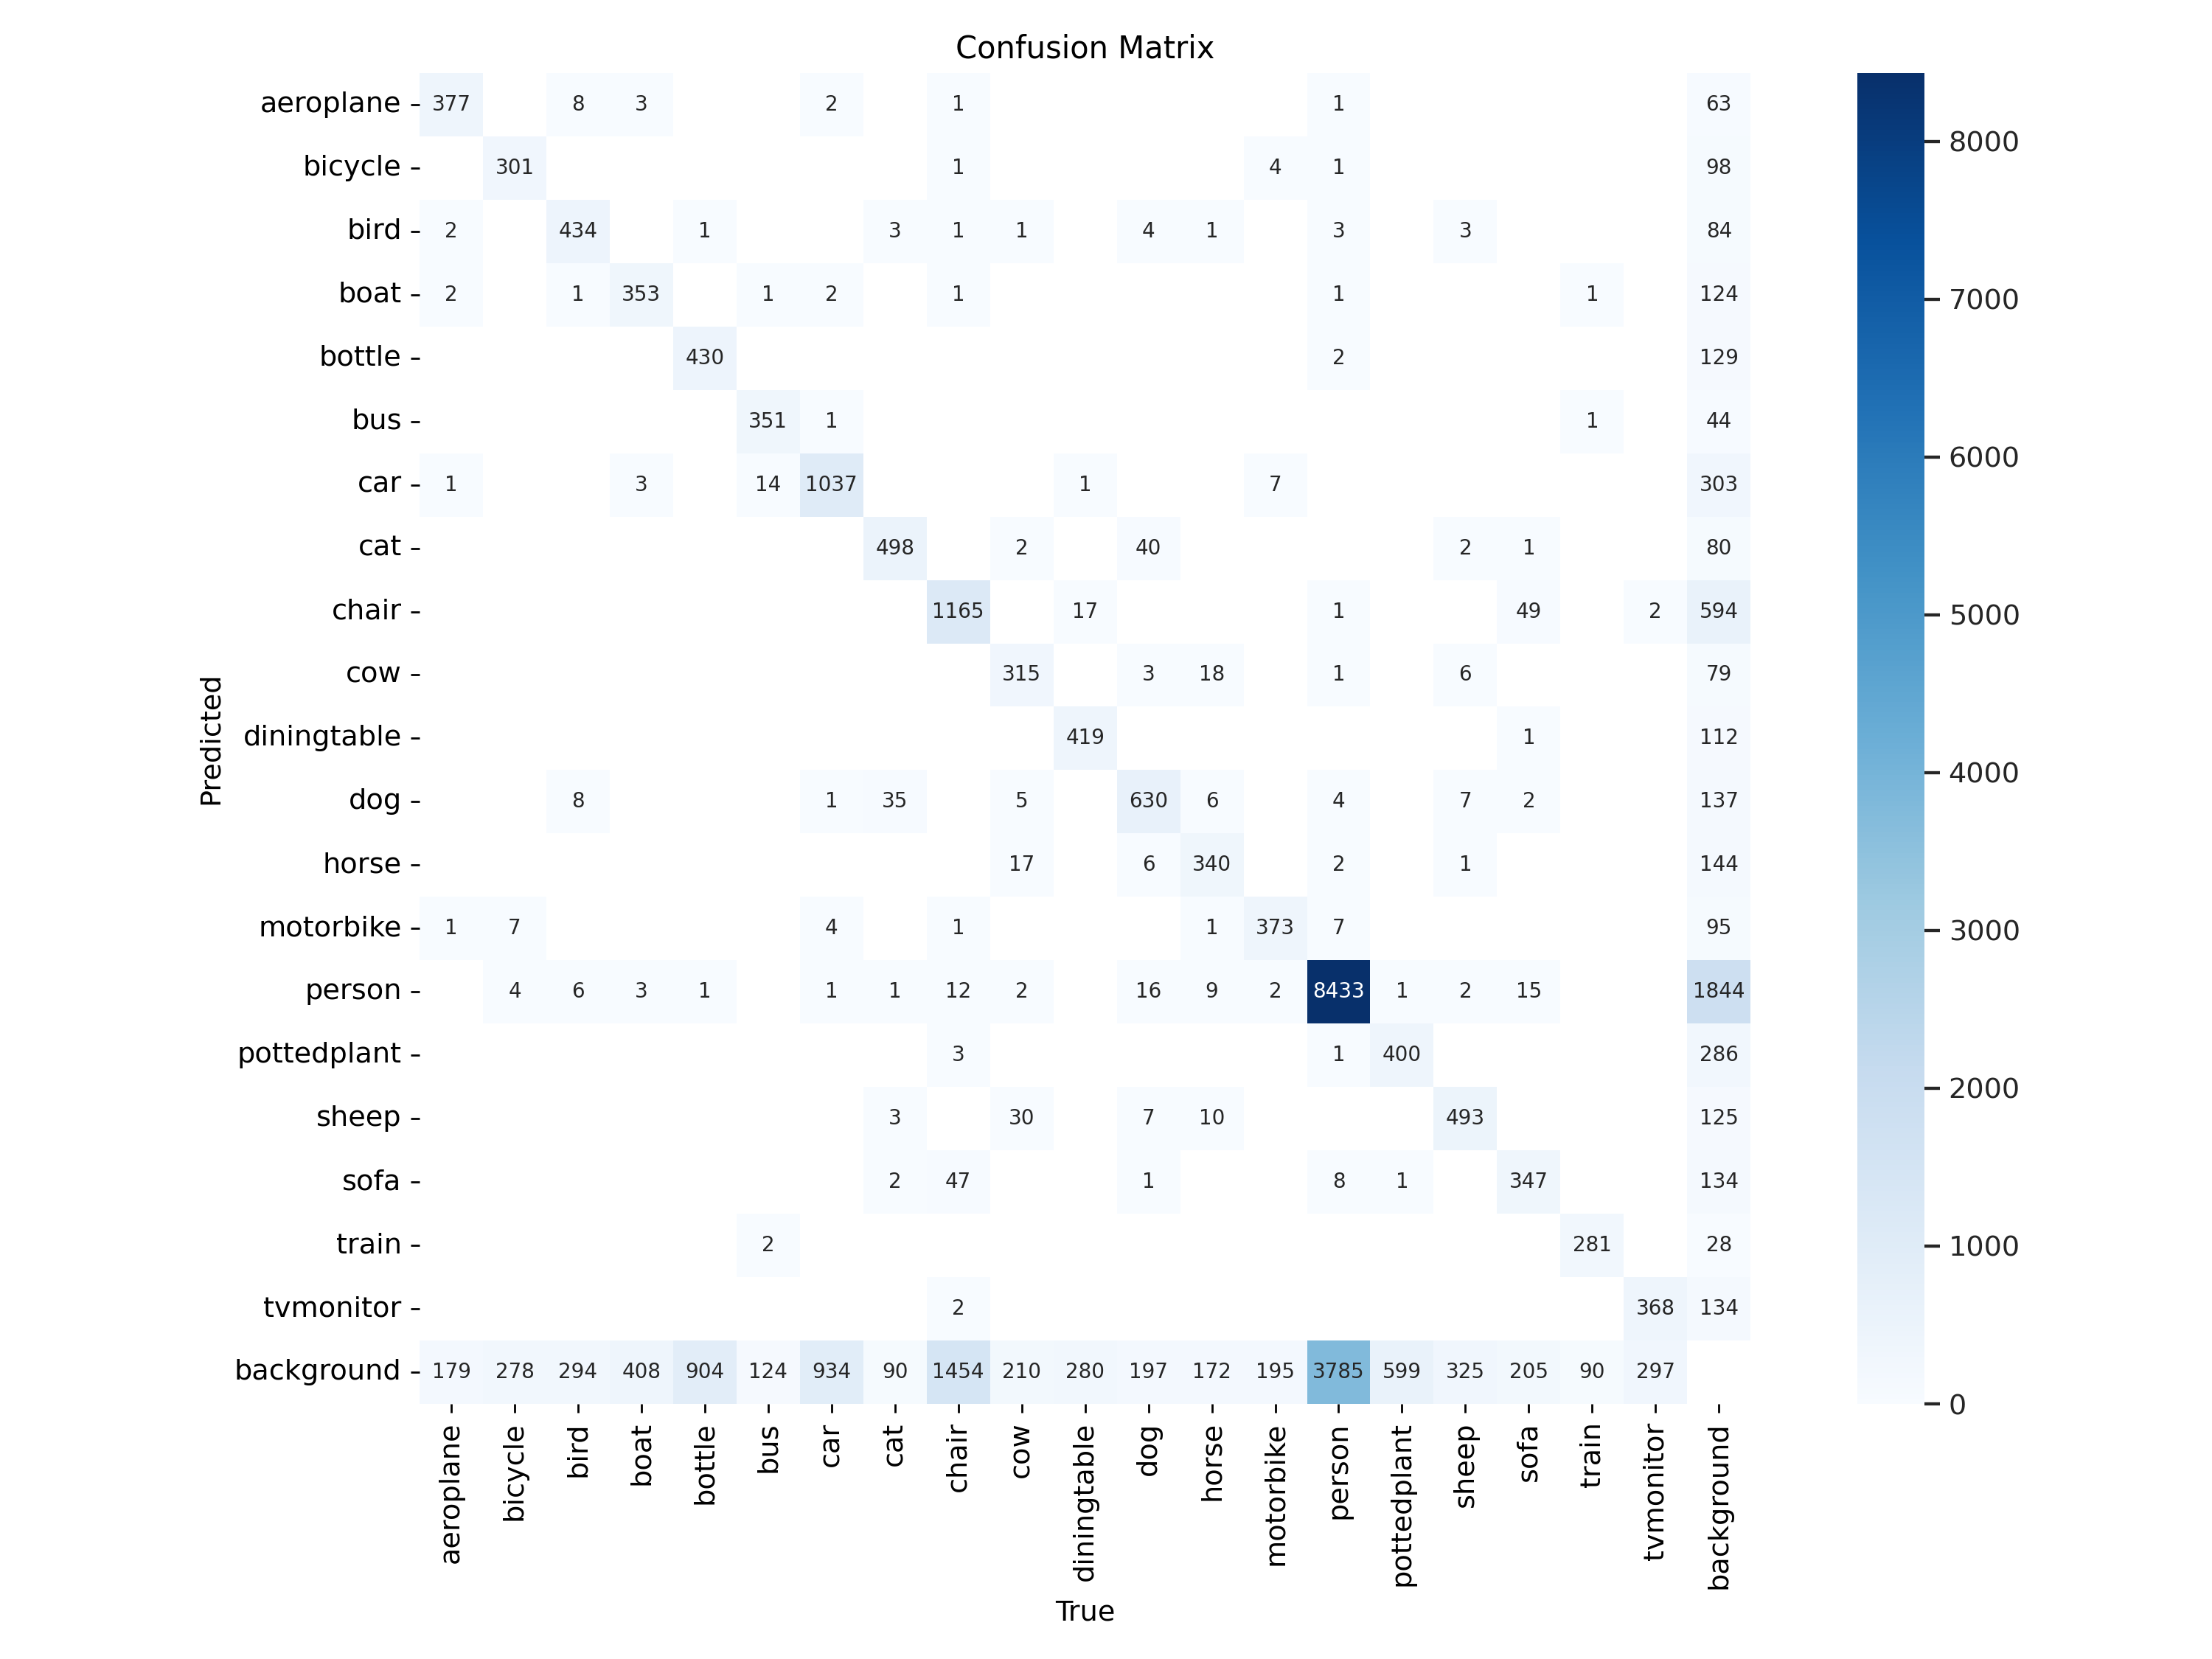

In [16]:
# 8. Visualisasi Hasil Pelatihan YOLOv8n (Grafik Loss, mAP, Precision, Recall)

from IPython.display import Image, display
import os

# Cek folder hasil pelatihan
!ls runs/detect/

# Tampilkan grafik training
train_dir = '/content/runs/detect/train5'  # Sesuaikan jika foldernya bernama train2, train3, dll

# Visualisasi loss dan mAP per epoch
display(Image(filename=os.path.join(train_dir, 'results.png')))

# Visualisasi confusion matrix
display(Image(filename=os.path.join(train_dir, 'confusion_matrix.png')))


# Analisis Kinerja Model (Tabel Perbandingan & Penjelasan)

| Model             | mAP@0.5 | Precision | Recall | Waktu Inferensi (1 img) | Ukuran Model | Cocok untuk MX130 |
|------------------|---------|-----------|--------|--------------------------|---------------|--------------------|
| YOLOv8n          | ✔ (hasil val) | ✔ (val)   | ✔ (val) | Cepat (~0.05s)           | ~6 MB        | ✔ Sangat cocok     |
| MobileNet-SSD    | ❌ (pretrained COCO) | ❌ | ❌ | Sangat cepat (~0.02s)     | ~20 MB       | ✔ Cocok            |
| Faster R-CNN     | ❌ (pretrained COCO) | ❌ | ❌ | Cukup lambat (~0.3s)      | ~160 MB      | ⚠ Berat            |


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
from google.colab import drive
import shutil, os

# Mount Google Drive
drive.mount('/content/drive')

# Buat folder tujuan di Drive
backup_dir = '/content/drive/MyDrive/yolov8_backup'
os.makedirs(backup_dir, exist_ok=True)

# 1️⃣ Salin folder dataset-ninja
src1 = '/content/dataset-ninja'
dst1 = os.path.join(backup_dir, 'dataset-ninja')
if os.path.exists(src1):
    shutil.copytree(src1, dst1, dirs_exist_ok=True)
    print("✅ Folder dataset-ninja berhasil disalin ke Drive.")
else:
    print("⚠️ Folder dataset-ninja tidak ditemukan.")

# 2️⃣ Salin folder runs
src2 = '/content/runs'
dst2 = os.path.join(backup_dir, 'runs')
if os.path.exists(src2):
    shutil.copytree(src2, dst2, dirs_exist_ok=True)
    print("✅ Folder runs berhasil disalin ke Drive.")
else:
    print("⚠️ Folder runs tidak ditemukan.")

# 3️⃣ Salin folder sample_data
src3 = '/content/sample_data'
dst3 = os.path.join(backup_dir, 'sample_data')
if os.path.exists(src3):
    shutil.copytree(src3, dst3, dirs_exist_ok=True)
    print("✅ Folder sample_data berhasil disalin ke Drive.")
else:
    print("⚠️ Folder sample_data tidak ditemukan.")

# 4️⃣ Salin folder yolo_dataset
src4 = '/content/yolo_dataset'
dst4 = os.path.join(backup_dir, 'yolo_dataset')
if os.path.exists(src4):
    shutil.copytree(src4, dst4, dirs_exist_ok=True)
    print("✅ Folder yolo_dataset berhasil disalin ke Drive.")
else:
    print("⚠️ Folder yolo_dataset tidak ditemukan.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 